In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import cross_val_score

In [2]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42
np.random.seed(seed)

### Generating the target function and its noisy version.

Geramos 30 amostras da seguinte função objetivo

$$y = 1 + 0.5 x + 2 x^2$$

In [3]:
# Sets the number of examples.
N = 30

# Attribute.
x = np.sort(2*np.random.rand(N, 1) - 1, axis=0)

# Target function.
y = 1 + 0.5*x + 2*x**2

# Noise.
w = np.sqrt(0.09)*np.random.randn(N, 1)

# Noisy function.
y_noisy = y + w

In [4]:
print('Média das amostras da função observável:', np.mean(y_noisy))

Média das amostras da função observável: 1.530915117847102


**Observação**

+ A média de $y_{noisy}$ é igual a $1.531$, pois sua esperança é igual a $1 + 2 \big(\frac{1}{3}\big)$.


+ Isso de deve ao fato do atributo $x^2$ ter esperança igual a $\frac{1}{3}$ e o atributo $x$ e o ruído $w$ terem esperanças iguais a zero, respectivamente.

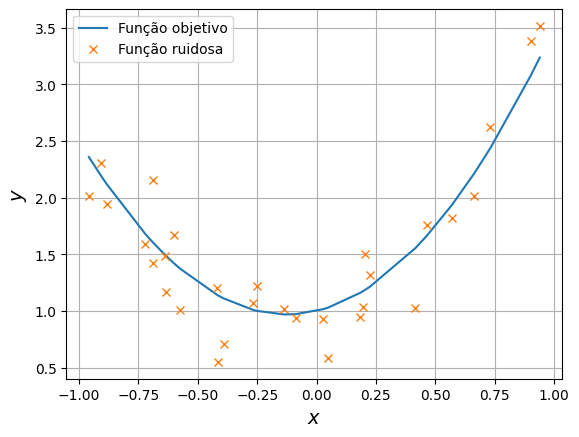

In [5]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("target_function.png", dpi=600)

#Show the plot.
plt.show()

### Define the polinomial order

In [6]:
# Polynomial order.
model_order = 15

### Define a list of regularization factors to be tested

In [7]:
# Regularization factor.
lambdas = [0, 0.0107, 1]

### LASSO regression with SciKit-Learn

Usamos a classe `Lasso` para realizar a regressão LASSO.

**Observações**

+ É importante sempre escalonar os atributos antes de executar qualquer tipo de regressão com regularização.


+ O parâmetro `alpha` da classe `Lasso` é o fator de regularização, $\lambda$, e não o passo de aprendizagem.

Lambda: 0.0000e+00:
[1.53091512]
[[-3.26619148e-01  6.26027965e+00  9.11715885e+00 -8.93092859e+01
  -9.13730327e+01  5.26147653e+02  5.43742416e+02 -1.51291387e+03
  -1.71566113e+03  2.27078228e+03  2.80890380e+03 -1.70290215e+03
  -2.25122856e+03  5.02976634e+02  6.97684255e+02]]
---------------------------------------------
Lambda: 1.0700e-02:
[1.53091512]
[ 0.21599717  0.60414186  0.09871964  0.02257206  0.01331585  0.
  0.00845307  0.          0.0060567   0.          0.00442557 -0.
  0.00347282 -0.          0.00293102]
---------------------------------------------
Lambda: 1.0000e+00:
[1.53091512]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
---------------------------------------------


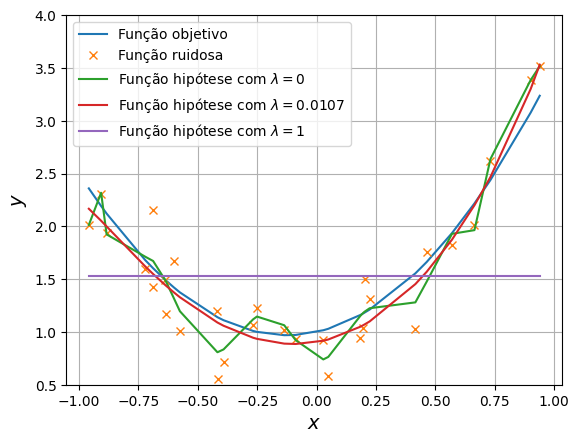

In [8]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
for i in range(0,len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=False)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()

    # Instantiate a Lasso regressor.
    # tol: a otimização continua enquanto as atualizações não forem menores que o valor definido para 'tol'.
    #      Quanto menor o valor de 'tol', mais precisa será a solução final, mas o treinamento levará mais tempo.
    # lambda = 0: devido a instabilidades numéricas, a documentação da classe Lasso não recomenda seu uso quando lambda = 0.
    reg = Lasso(alpha=lambdas[i], tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()

    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Train model.
    model.fit(x, y_noisy)
    # Print coefs
    print('Lambda: %1.4e:' % (lambdas[i]))
    print(model.named_steps['reg'].intercept_)
    print(model.named_steps['reg'].coef_[0:model_order])
    # Predict.
    y_test_regul = model.predict(x)
    print('---------------------------------------------')

    # Plot prediction.
    plt.plot(x, y_test_regul, label='Função hipótese com $\lambda=$'+str(lambdas[i]))

plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
# Save figure
#plt.savefig("lasso_regression.png", dpi=600)

#Show the plot.
plt.show()

#### Conclusões:

+ Valores pequenos de $\lambda$ fazem LASSO se comportar como regressão tradicional e valores muito grandes fazem os pesos serem anulados (**região de factibilidade nula**).


+ A regularização com norma L1 tem como **vantagem a produção de modelos esparsos**.
    + Ou seja, vários elementos do vetor de pesos acabam sendo anulados, indicando que os atributos correspondentes são irrelevantes para o processo de regressão.


+ Isso sugere a ocorrência implícita de um processo de **seleção automática de atributos**, que leva a modelos mais regulares, ou seja, menos complexos.


+ **Desvantagem**: como a norma L1 não possui derivada no ponto $a_i=0\;, \forall i$, o problema da minimização **não possui solução em forma fechada**, mas **pode ser implementado com o gradiente descendente**.


+ Utiliza-se técnicas de **validação cruzada** para encontrar o valor ideal de  $\lambda$.

### Weight variation versus lambda (i.e., regularization factor)

Cria uma sequência de 5000 valores linearmente espaçados para o fator de regularização, variando de $1e^{-4}$ até $1$.

In [9]:
M = 5000
lambdas = np.linspace(1e-4, 1, M)

# Leave-one-out
lpocv = LeavePOut(p=1)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=False)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Lasso regressor.
    reg = Lasso(alpha=lambdas[i], tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Cross-validation
    lin_scores = cross_val_score(model, x, y_noisy, scoring='neg_mean_squared_error', cv=lpocv, n_jobs=-1)

    # Convert back to MSE by multiplying it by minus one.
    scores = -lin_scores
    # Mean of the MSE values, i.e., calculate ter MSE for each one of the folds.
    error_test.append(scores.mean())

    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[0:model_order]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a, ord=1)

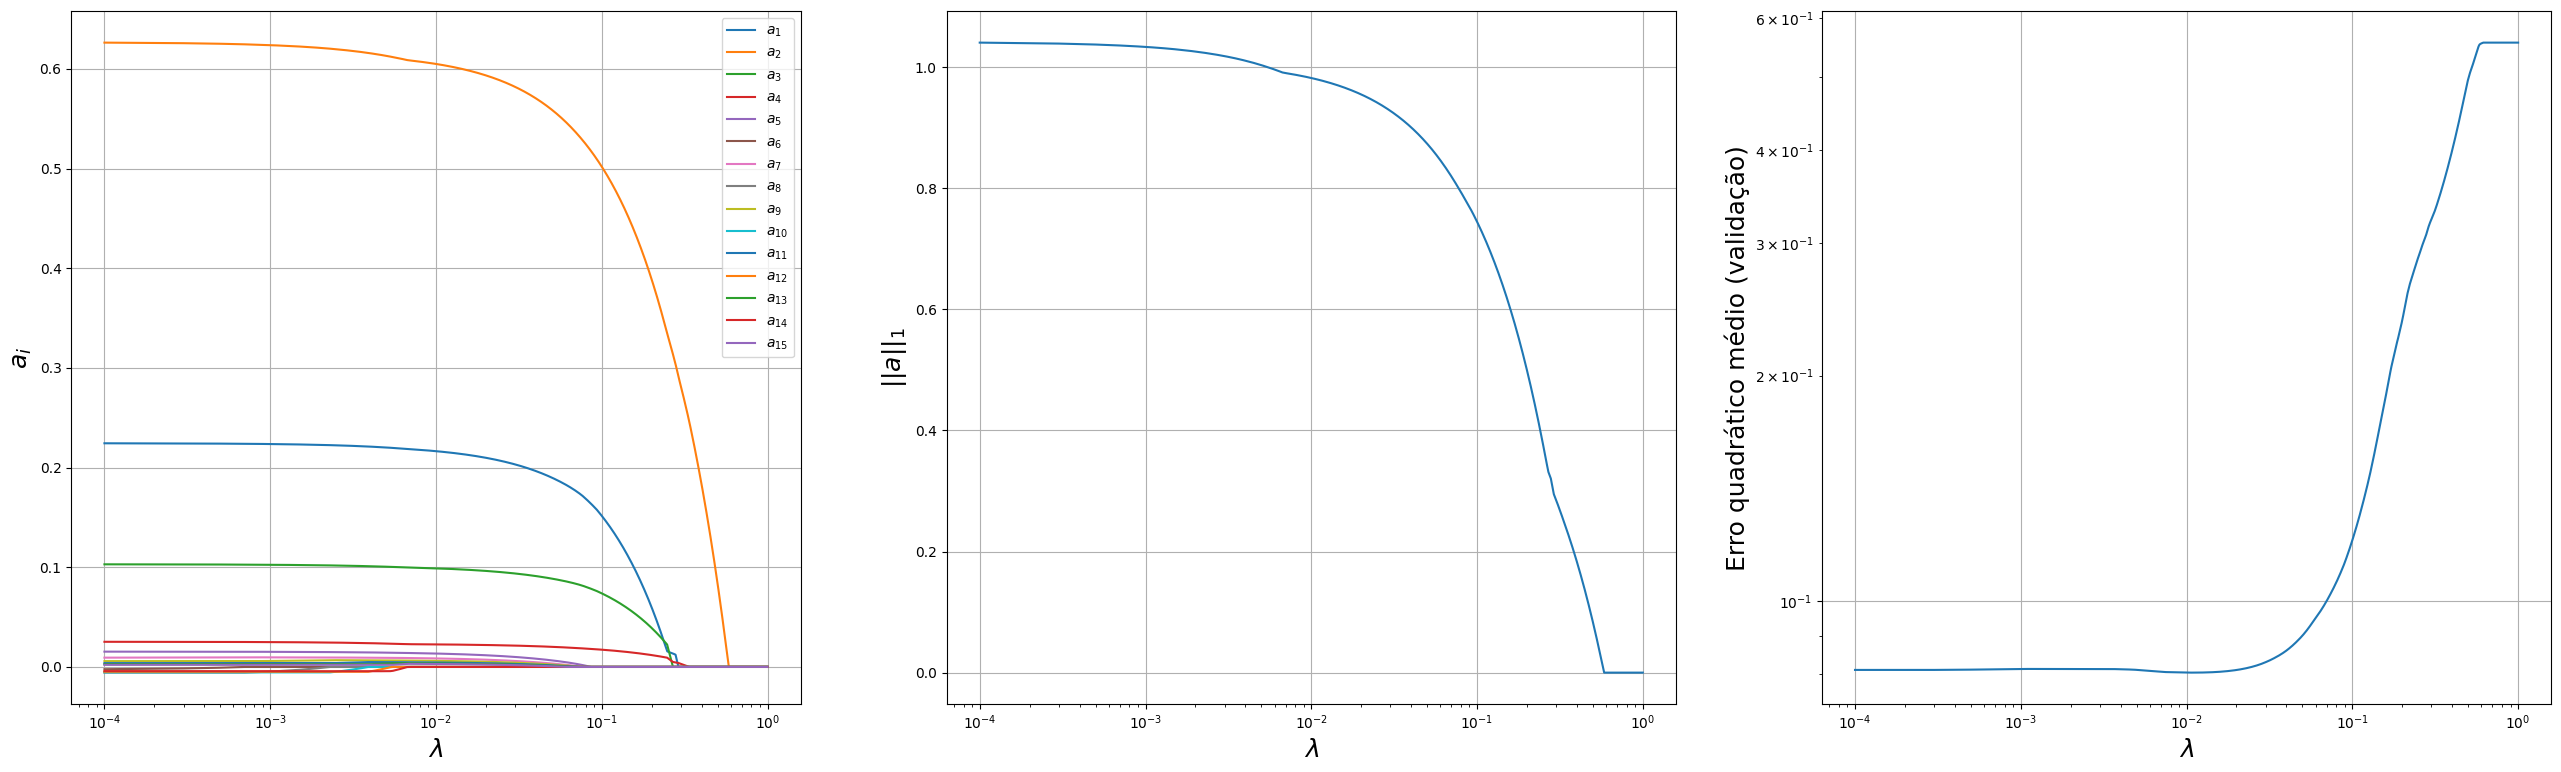

In [10]:
# Create figure.
fig = plt.figure(figsize=(32,9))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0,model_order):
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$a_i$', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
# Save figure
#plt.savefig("lasso_regression_pesos.png", dpi=600)

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$||a||_1$', fontsize=18)
plt.grid()
# Save figure
#plt.savefig("lasso_regression_norma.png", dpi=600)

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('Erro quadrático médio (validação)', fontsize=18)
plt.grid()
# Save figure
#plt.savefig("lasso_regression_mse.png", dpi=600)

#Show the plot.
plt.show()

### Obtendo o melhor $\lambda$.

In [11]:
# Obtém o índice com o menor erro.
min_idx = np.argmin(error_test)
print('idx: %d - MSE min: %f - best lambda: %f' % (min_idx, error_test[min_idx], lambdas[min_idx]))

idx: 53 - MSE min: 0.080318 - best lambda: 0.010701


+ Para valores de $\lambda$ maiores do que $0.6$, a norma L1 dos pesos é tende a 0.


+ Para valores de $\lambda$ tendendo a 0, o modelo **sobreajusta**, pois a região de factibilidade é muito grande.


+ Quando $\lambda$ é aproximadamente $0.01$, o modelo se aproxima da função geradora (menor erro).
    + Ou seja, o modelo encontra um boa relação de compromisso entre os erros de variância e de viés.


+ Para valores de $\lambda$ maiores do que $0.01$, o modelo tende ao valor constante igual à média dos dados de treinamento (reta), o que faz o erro aumentar, pois o modelo **subajusta** (região de factibilidade é muito pequena).

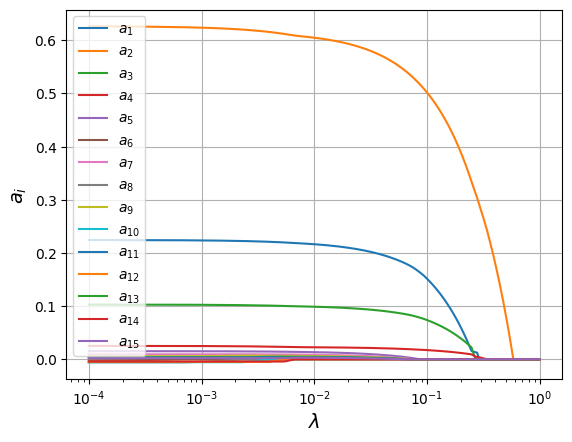

In [12]:
# Plot weight.
for i in range(0, model_order):
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper left')
plt.grid()

#Show the plot.
plt.show()

### Using cross-validation for finding the best $\lambda$

Usamos a classe `LassoCV` para encontrar o valor ideal de $\lambda$.


In [13]:
M = 5000

# Leave-one-out
lpocv = LeavePOut(p=1)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=False)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Lasso regressor.
reg = LassoCV(n_alphas=M, tol=1, cv=lpocv, random_state=seed, n_jobs=-1)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

clf.fit(x, y_noisy.ravel())

y_pred = clf.predict(x)

#### Melhor valor encontrado.

In [14]:
clf['reg'].alpha_

0.001821061873878304

### Comparing the results

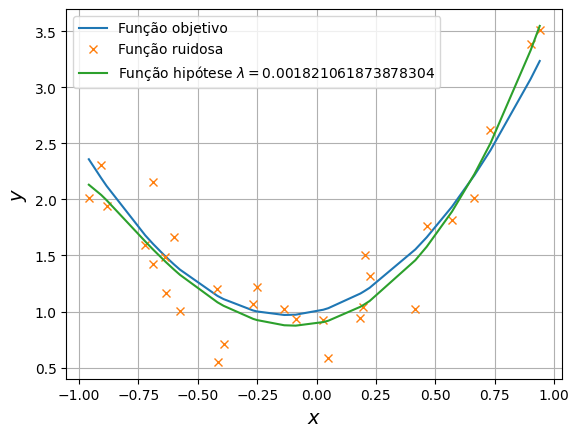

In [15]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
plt.plot(x, y_pred, label='Função hipótese $\lambda=$'+str(clf['reg'].alpha_))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

### Comparando os valores de $\lambda$ obtidos com a validação cruzada implementada de forma manual e com a classe `LassoCV`

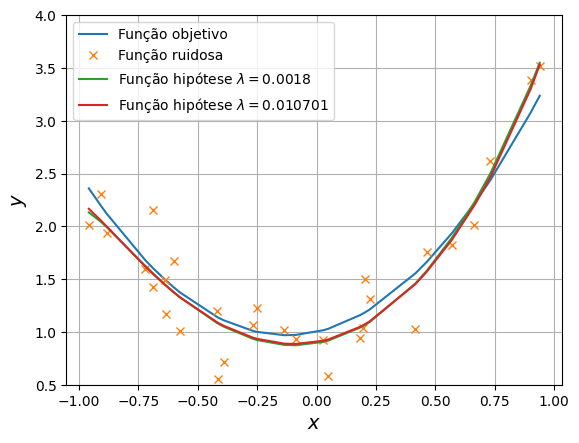

In [16]:
# Regularization factor.
lambdas = [0.0018, 0.010701]

# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
for i in range(0, len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=False)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Lasso regressor.
    reg = Lasso(alpha=lambdas[i], tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()

    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    # Predict.
    y_test_regul = model.predict(x)
    # Plot prediction.
    plt.plot(x, y_test_regul, label='Função hipótese $\lambda=$'+str(lambdas[i]))

plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
# Save figure
#plt.savefig("lasso_regression.png", dpi=600)

#Show the plot.
plt.show()

### Conclusão

Existe um intervalo de valores de $\lambda$ que faz com que o modelo apresente uma boa relação de compromisso entre os erros de variância e viés, se aproximando da função geradora.

### Referências

[1] "what is max_iter and tol in Lasso Regularizer sklearn", https://stackoverflow.com/questions/66487819/what-is-max-iter-and-tol-in-lasso-regularizer-sklearn